Import necessary libraries

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

In [101]:
X = pd.read_csv("StellarData.csv") #load datset

In [102]:
X.info() #get some basic info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9150 entries, 0 to 9149
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Right_Ascention  9150 non-null   float64
 1   Declination      9150 non-null   float64
 2   u                9150 non-null   float64
 3   g                9150 non-null   float64
 4   r                9150 non-null   float64
 5   i                9150 non-null   float64
 6   z                9150 non-null   float64
 7   Run_Number       9150 non-null   int64  
 8   Rerun_Number     9150 non-null   int64  
 9   Camera_Column    9150 non-null   int64  
 10  Field_Number     9150 non-null   int64  
 11  specobjid        9150 non-null   float64
 12  class            9150 non-null   object 
 13  redshift         9150 non-null   float64
 14  plate            9150 non-null   int64  
 15  mjd              9150 non-null   int64  
 16  fiberid          9150 non-null   int64  
dtypes: float64(9),

In [103]:
y = X.pop("class") #remove target variable to keep it independent
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69) #split dataset to preserve an independent test set for testing model

In [104]:
X.describe()

,Right_Ascention,Declination,u,g,r,i,z,Run_Number,Rerun_Number,Camera_Column,Field_Number,specobjid,redshift,plate,mjd,fiberid
count,9150.000000,9150.000000,9150.000000,9150.000000,9150.000000,9150.000000,9150.000000,9150.000000,9150.0,9150.000000,9150.000000,9.150000e+03,9150.000000,9150.000000,9150.000000,9150.000000
mean,175.349953,14.303436,18.589297,17.250536,16.686981,16.418556,16.250796,975.917596,301.0,3.644481,302.138251,1.663396e+18,0.043896,1477.306448,52966.687104,350.422842
std,47.844894,24.879069,0.842478,0.876612,0.961771,1.027774,1.085480,272.211353,0.0,1.665374,162.636560,1.986829e+18,0.052491,1764.647895,1503.083498,205.659557
min,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,157.584047,-0.541007,18.124177,16.737642,16.103342,15.790297,15.551233,752.000000,301.0,2.000000,185.000000,3.400232e+17,0.000050,302.000000,51900.000000,183.000000
50%,180.326741,0.384792,18.822605,17.415660,16.757515,16.448885,16.263595,756.000000,301.0,4.000000,299.000000,4.989465e+17,0.030734,443.000000,51999.000000,347.000000
75%,201.069175,14.646150,19.246002,17.893400,17.369435,17.097865,16.959817,1331.000000,301.0,5.000000,413.000000,2.881348e+18,0.080849,2559.000000,54468.000000,508.000000
max,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,0.855881,8410.000000,57481.000000,1000.000000


In [105]:
target = LabelEncoder()
y_train = target.fit_transform(y_train)  #y_train and y_test have values "Galaxy" and "Star"
y_test = target.transform(y_test)

In [106]:
mi = mutual_info_classif(X_train,y_train)
mi = np.sort(mi)[::-1]  #get mi scores for seeing relations between various columns with target

<Axes: xlabel='mutual info', ylabel='features'>

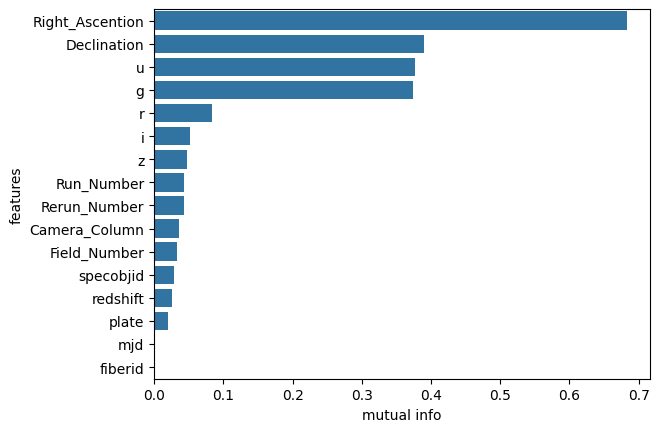

In [107]:
feature_names = X_train.columns

plt.xlabel("mutual info")
plt.ylabel("features")
sns.barplot(x = mi, y = feature_names)

Right_Ascention, Declination, u and g have a very high mutual info score, so they will be considered

In [108]:
X_train.Rerun_Number.value_counts()

Rerun_Number
301    7320
Name: count, dtype: int64

In [109]:
X_train.drop(["Rerun_Number"], axis = 1, inplace = True) #all rows have same value, so not useful to consider

In [110]:
for col in X_train.columns:
  grp1 = X_train[col][y_train == 0]
  grp2 = X_train[col][y_train == 1]

  f_stat, p_val = f_oneway(grp1, grp2)

  print(f"ANOVA results for {col}: F-statistic = {f_stat}, p-value = {p_val}") #doing ANOVA test to check relations which mutual_info_classif might have missed/overlooked

ANOVA results for Right_Ascention: F-statistic = 17.791723648313067, p-value = 2.4942502251720275e-05
ANOVA results for Declination: F-statistic = 40.77844395573415, p-value = 1.8092880849693136e-10
ANOVA results for u: F-statistic = 622.0379389781372, p-value = 7.638987109212996e-132
ANOVA results for g: F-statistic = 122.93622650074715, p-value = 2.419506216794605e-28
ANOVA results for r: F-statistic = 10.92204898979223, p-value = 0.0009548345717828579
ANOVA results for i: F-statistic = 171.3999440491204, p-value = 9.94495562304233e-39
ANOVA results for z: F-statistic = 410.0394072562298, p-value = 9.385074465729394e-89
ANOVA results for Run_Number: F-statistic = 55.87951961164823, p-value = 8.600235040380481e-14
ANOVA results for Camera_Column: F-statistic = 0.07713056756353086, p-value = 0.7812321538168475
ANOVA results for Field_Number: F-statistic = 0.0338041151739283, p-value = 0.8541291993680123
ANOVA results for specobjid: F-statistic = 4521.220730510545, p-value = 0.0
ANOVA r

Apart from the above columns considered, r, i, z, Run_Number, fiberid also have strong relation with target, so will be considered

In [111]:
final_cols = ['Right_Ascention', 'Declination', 'u', 'g', 'r', 'i', 'z', 'Run_Number', 'fiberid']

X_train = X_train[final_cols]
X_test = X_test[final_cols]   #keeping only important columns for training model

In [112]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

cols_scaled = ['Right_Ascention', 'Declination', 'u', 'g', 'r', 'i', 'z']
X_train_scaled[cols_scaled] = scaler.fit_transform(X_train[cols_scaled])  #scaling features to make distributions more uniform
X_test_scaled[cols_scaled] = scaler.transform(X_test[cols_scaled])

In [113]:
dt_model = DecisionTreeClassifier(random_state = 69)
rf_model = RandomForestClassifier(random_state = 69)
hgb_model = HistGradientBoostingClassifier(random_state = 69)   #I am considering only these three, there are other models which can be better, but I don't have sufficient knowledge about others

In [117]:
dt_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

rf_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

hgb_grid = {
    'learning_rate': [0.1, 0.01, 0.01],
    'max_iter': [100, 300, 500],
    'max_leaf_nodes': [None, 10, 20],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }                                                  #making parameter_distributions for searching best parameters using RandomizedSearchCV


In [118]:
dt_grid_search = RandomizedSearchCV(estimator=dt_model, param_distributions=dt_grid, cv=5, scoring='accuracy')

dt_grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", dt_grid_search.best_params_)
print("Best CV Score:", dt_grid_search.best_score_)

Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': None}
Best CV Score: 0.894808743169399


In [119]:
rf_grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_grid, cv=5, scoring='accuracy')

rf_grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", rf_grid_search.best_params_)
print("Best CV Score:", rf_grid_search.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Best CV Score: 0.9300546448087431


In [120]:
hgb_grid_search = RandomizedSearchCV(estimator=hgb_model, param_distributions=hgb_grid, cv=5, scoring='accuracy')

hgb_grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", hgb_grid_search.best_params_)
print("Best CV Score:", hgb_grid_search.best_score_)

Best Parameters: {'min_samples_leaf': 2, 'max_leaf_nodes': None, 'max_iter': 300, 'max_depth': 10, 'learning_rate': 0.1}
Best CV Score: 0.9453551912568307


HistGradientBoostingClassifier gave best accuracy, so will consider it first (if cross val scores are bad will consider Random forest and decision tree)

In [121]:
best_hist_model = hgb_grid_search.best_estimator_

kf = KFold(n_splits=5, shuffle=True, random_state=69)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

kf_scores = cross_val_score(best_hist_model, X_train, y_train, cv = kf, scoring = 'accuracy')
skf_scores = cross_val_score(best_hist_model, X_train, y_train, cv = skf, scoring = 'accuracy')

print("KFold Accuracy:", kf_scores)
print("StratifiedKFold Accuracy:", skf_scores)

KFold Accuracy: [0.93647541 0.94808743 0.93579235 0.94603825 0.94535519]
StratifiedKFold Accuracy: [0.95013661 0.94262295 0.93852459 0.95081967 0.93579235]


Accuracy is quite good, so HistGradientBoostingClassifier will be taken as final model

In [122]:
y_pred = best_hist_model.predict(X_test_scaled)

preds = target.inverse_transform(y_pred)

              precision    recall  f1-score   support

      Galaxy       0.96      0.93      0.95       978
        Star       0.93      0.96      0.94       852

    accuracy                           0.94      1830
   macro avg       0.94      0.94      0.94      1830
weighted avg       0.94      0.94      0.94      1830



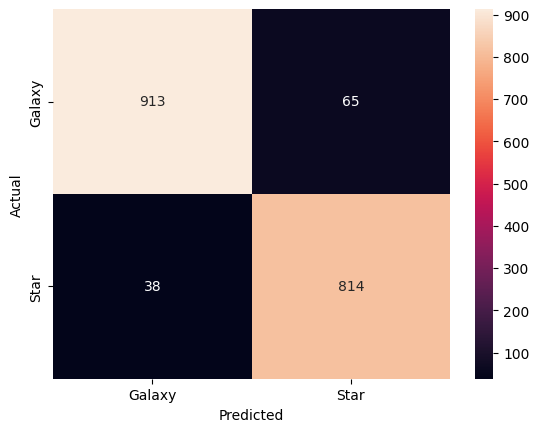

In [123]:
labels = ["Galaxy", "Star"]

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

rept = classification_report(y_test, y_pred, target_names = labels)
print(rept)

As can be seen from the classification report and confusion matrix, the model performed quite well on the unseen testing set (X_test and y_test here). So it can be used for further analysis